# University of Cologne Partner Universities 2018

In this small project I scrape the 2018 partner universities of the University of Cologne's Faculty of Management, Economics and Social Sciences. I also perform a short exploratory data analysis and create some visualizations.

See the current list of partner universities here: http://www.international.wiso.uni-koeln.de/international-profile/partner-universities/

## Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from bs4 import BeautifulSoup

In [2]:
sns.set()

In [3]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [4]:
init_notebook_mode(connected=True)

## Scraping and Wrangling Data

In [5]:
page = requests.get('http://www.international.wiso.uni-koeln.de/international-profile/partner-universities/')

In [6]:
soup = BeautifulSoup(page.content,'html.parser')

In [7]:
#create lists to build key word lists to find relevant data in html

numbers = [str(item) for item in range(1,7)]
region_id_1 = ['c189440_akkordeon_' for item in range (1,7)]
region_id_2 = ['-titel1' for item in range (1,7)]

In [8]:
#create list to find region in html
#region are located in html at the following ids

region_ids = [id1+num+id2 for id1,num,id2 in zip(region_id_1,numbers,region_id_2)]
region_ids

['c189440_akkordeon_1-titel1',
 'c189440_akkordeon_2-titel1',
 'c189440_akkordeon_3-titel1',
 'c189440_akkordeon_4-titel1',
 'c189440_akkordeon_5-titel1',
 'c189440_akkordeon_6-titel1']

In [9]:
#create list to find countries and universities in html
#countries and universities are located in html at the following ids

region_input_ids = [id1+num+'-1' for id1,num in zip(region_id_1,numbers)]
region_input_ids

['c189440_akkordeon_1-1',
 'c189440_akkordeon_2-1',
 'c189440_akkordeon_3-1',
 'c189440_akkordeon_4-1',
 'c189440_akkordeon_5-1',
 'c189440_akkordeon_6-1']

In [10]:
#find region in html

region_names = [soup.find(id=id).get_text().strip() for id in region_ids]
region_names

['Africa', 'Americas', 'Asia', 'Europe', 'Middle East', 'Oceania']

In [11]:
#create data frames from lists with region names, region ids and region input ids
#join data frames (will be used later to map regions and ids to countries and universities)

df_region_names = pd.DataFrame(region_names)
df_region_names.columns = ['Region']

df_region_ids = pd.DataFrame(region_ids)
df_region_ids.columns = ['Region IDs']

df_region_input_ids = pd.DataFrame(region_input_ids)
df_region_input_ids.columns = ['Region Input IDs']

df_region_names_ids = df_region_names.join(df_region_ids)
df_region_mapping = df_region_names_ids.join(df_region_input_ids)
df_region_mapping

,Region,Region IDs,Region Input IDs
0,Africa,c189440_akkordeon_1-titel1,c189440_akkordeon_1-1
1,Americas,c189440_akkordeon_2-titel1,c189440_akkordeon_2-1
2,Asia,c189440_akkordeon_3-titel1,c189440_akkordeon_3-1
3,Europe,c189440_akkordeon_4-titel1,c189440_akkordeon_4-1
4,Middle East,c189440_akkordeon_5-titel1,c189440_akkordeon_5-1
5,Oceania,c189440_akkordeon_6-titel1,c189440_akkordeon_6-1


In [12]:
#find countries in html

countries = []

for id in region_input_ids:
    country_names = list(soup.find(id=id).find_all('b'))

    country_names = [str(item) for item in country_names]
    country_names = [re.sub('<b>','',item) for item in country_names]
    country_names = [re.sub('</b>','',item) for item in country_names]
    country_names = [re.sub('<br/>','',item) for item in country_names]
    country_names = [item+'split_here'+id for item in country_names]
    country_names = [item.split('split_here') for item in country_names]
    
    countries.extend(country_names)
    
countries[:5]

[['Egypt', 'c189440_akkordeon_1-1'],
 ['Ghana', 'c189440_akkordeon_1-1'],
 ['Senegal', 'c189440_akkordeon_1-1'],
 ['South Africa', 'c189440_akkordeon_1-1'],
 ['Argentina', 'c189440_akkordeon_2-1']]

In [13]:
#create data frame from list with countries and region input ids

df_countries = pd.DataFrame(countries)
df_countries.columns = ['Country','Region Input IDs']
df_countries.head()

,Country,Region Input IDs
0,Egypt,c189440_akkordeon_1-1
1,Ghana,c189440_akkordeon_1-1
2,Senegal,c189440_akkordeon_1-1
3,South Africa,c189440_akkordeon_1-1
4,Argentina,c189440_akkordeon_2-1


In [14]:
#merge countries with regions and id mapping

df_region_country_mapping = pd.merge(df_countries,df_region_mapping,how='left',on='Region Input IDs')
df_region_country_mapping['Country'] = df_region_country_mapping['Country'].apply(lambda string: string.strip())
df_region_country_mapping.head()

,Country,Region Input IDs,Region,Region IDs
0,Egypt,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
1,Ghana,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
2,Senegal,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
3,South Africa,c189440_akkordeon_1-1,Africa,c189440_akkordeon_1-titel1
4,Argentina,c189440_akkordeon_2-1,Americas,c189440_akkordeon_2-titel1


In [15]:
#find countries and universities in html

countries_universities = []

for id in region_input_ids:

    countries_universities_raw = list(soup.find(id=id).find_all('p'))
    
    countries_universities_raw = [item.get_text('_') for item in countries_universities_raw]
    countries_universities_raw = [item.split('_') for item in countries_universities_raw]
    
    countries_universities.extend(countries_universities_raw)
    
countries_universities[:5]

[['Egypt', 'The American University in Cairo'],
 ['Ghana', 'GIMPA – Ghana Institute of Management and Public Administration'],
 ['Senegal', 'Institut Africain de Management, Dakar'],
 ['South Africa',
  'University of Capetown, Graduate School of Business',
  'University of Stellenbosch Business School',
  'University of Witwatersrand, Wits Business School'],
 ['Argentina', 'Universidad Torcuato di Tella']]

In [16]:
#remove empty items from list with countries and universities

for list in countries_universities:
    while ' ' in list: list.remove(' ')

In [17]:
#create data frame from list with countries and universities

df_countries_universities = pd.DataFrame(countries_universities)
df_countries_universities.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,Egypt,The American University in Cairo,None,None,None,None,None,None,None,None,None,None,None
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,None,None,None,None,None,None,None,None,None,None,None
2,Senegal,"Institut Africain de Management, Dakar",None,None,None,None,None,None,None,None,None,None,None
3,South Africa,"University of Capetown, Graduate School of Bus...",University of Stellenbosch Business School,"University of Witwatersrand, Wits Business School",None,None,None,None,None,None,None,None,None
4,Argentina,Universidad Torcuato di Tella,None,None,None,None,None,None,None,None,None,None,None


In [18]:
#transform data frame from list with countries and universities

df_melt_countries_universities = pd.melt(df_countries_universities, id_vars=0)
df_melt_countries_universities = df_melt_countries_universities.dropna().drop(columns='variable')
df_melt_countries_universities.columns = ['Country','University']
df_final_countries_universities = df_melt_countries_universities.reset_index().drop(columns='index')
df_final_countries_universities['Country'] = df_final_countries_universities['Country'].apply(lambda string: string.strip())
df_final_countries_universities['University'] = df_final_countries_universities['University'].apply(lambda string: string.strip())
df_final_countries_universities.head()

,Country,University
0,Egypt,The American University in Cairo
1,Ghana,GIMPA – Ghana Institute of Management and Publ...
2,Senegal,"Institut Africain de Management, Dakar"
3,South Africa,"University of Capetown, Graduate School of Bus..."
4,Argentina,Universidad Torcuato di Tella


In [19]:
#merge countries and universities with region mapping

df_final_countries_universities_map = pd.merge(df_final_countries_universities,df_region_country_mapping,how='outer',on='Country')
df_final_countries_universities_map.drop(columns=['Region Input IDs','Region IDs'],inplace=True)
df_final_countries_universities_map.head()

,Country,University,Region
0,Egypt,The American University in Cairo,Africa
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,Africa
2,Senegal,"Institut Africain de Management, Dakar",Africa
3,South Africa,"University of Capetown, Graduate School of Bus...",Africa
4,South Africa,University of Stellenbosch Business School,Africa


In [20]:
#universities in africa

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Africa']

,Country,University,Region
0,Egypt,The American University in Cairo,Africa
1,Ghana,GIMPA – Ghana Institute of Management and Publ...,Africa
2,Senegal,"Institut Africain de Management, Dakar",Africa
3,South Africa,"University of Capetown, Graduate School of Bus...",Africa
4,South Africa,University of Stellenbosch Business School,Africa
5,South Africa,"University of Witwatersrand, Wits Business School",Africa


In [21]:
#universities in the americas

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Americas']

,Country,University,Region
6,Argentina,Universidad Torcuato di Tella,Americas
7,Brazil,Escola de Administracao de Empresas de Sao Paolo,Americas
8,Canada,"Mc Gill University, Desautels Faculty of Manag...",Americas
9,Canada,Université du Montréal à Quebec,Americas
10,Canada,"University of British Columbia, Sauder School ...",Americas
11,Canada,"University of Calgary, Haskayne School of Busi...",Americas
12,Canada,"University of Victoria, Peter B. Gustavson Sch...",Americas
13,Canada,"The University of Western Ontario, Richard Ive...",Americas
14,Chile,Pontificia Universidad Católica de Chile,Americas
15,Chile,Universidad Adolfo Ibáñez,Americas


In [22]:
#universities in asia

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Asia']

,Country,University,Region
27,China,"Fudan University, School of Management",Asia
28,China,HKUST – Hongkong University of Science and Tec...,Asia
29,China,"Peking University, HSBC Business School",Asia
30,China,Shanghai University of Finance and Economics,Asia
31,China,"Sun Yat-Sen University, Sun Yat-Sen Business S...",Asia
32,China,"Tsinghua University, School of Economics und M...",Asia
33,China,UIBE – University of International Business an...,Asia
34,China,"The Chinese University of Hong Kong, Shenzhen",Asia
35,India,"Indian Institute of Management, Ahmedabad",Asia
36,India,"Indian Institute of Management, Bangalore",Asia


In [23]:
#universities in europe

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Europe']

,Country,University,Region
52,Austria,Vienna University of Economics and Business,Europe
53,Belgium,KU Leuven,Europe
54,Belgium,"Université Catholique de Louvain, Louvain Scho...",Europe
55,Bulgaria,Sofia University Kliment Ohridski,Europe
56,Croatia,University of Zagreb,Europe
57,Czech Republic,Universitas Carolina Pragensis,Europe
58,Czech Republic,VSE – University of Economics Prague,Europe
59,Denmark,"Aarhus University, School of Business and Soci...",Europe
60,Denmark,Copenhagen Business School,Europe
61,Denmark,University of Copenhagen,Europe


In [24]:
#universities in the middle east

df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Middle East']

,Country,University,Region
136,Israel,"University of Tel Aviv, Coller School of Manag...",Middle East


In [25]:
df_final_countries_universities_map[df_final_countries_universities_map['Region']=='Oceania']

,Country,University,Region
137,Australia,"The University of New South Wales, Australian ...",Oceania
138,Australia,"The University of Melbourne, Melbourne Busines...",Oceania
139,Australia,The University of Sydney Business School,Oceania
140,New Zealand,"University of Otago, Otago School of Business",Oceania


# Exploratory Data Analysis and Visualizations

In [26]:
#number of universities per region

df_final_countries_universities_map['Region'].value_counts()

Europe         84
Asia           25
Americas       21
Africa          6
Oceania         4
Middle East     1
Name: Region, dtype: int64

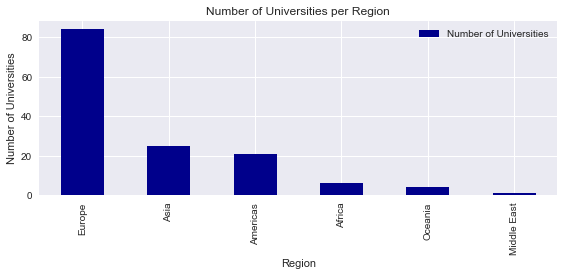

In [27]:
#histogram of universities per region

universities_per_region = pd.DataFrame(df_final_countries_universities_map['Region'].value_counts()).reset_index()
universities_per_region.columns = ['Region','Number of Universities']

universities_per_region.plot(x='Region',
                             y='Number of Universities',
                             kind='bar',
                             color='darkblue',
                             figsize=(8,4),
                             title='Number of Universities per Region')
plt.ylabel('Number of Universities')
plt.tight_layout()

In [28]:
#top 10 countries with most universities

df_final_countries_universities_map['Country'].value_counts().head(10)

France           12
Great Britain    10
China             8
USA               8
Spain             7
Canada            6
Turkey            5
Italy             5
Portugal          4
Ireland           4
Name: Country, dtype: int64

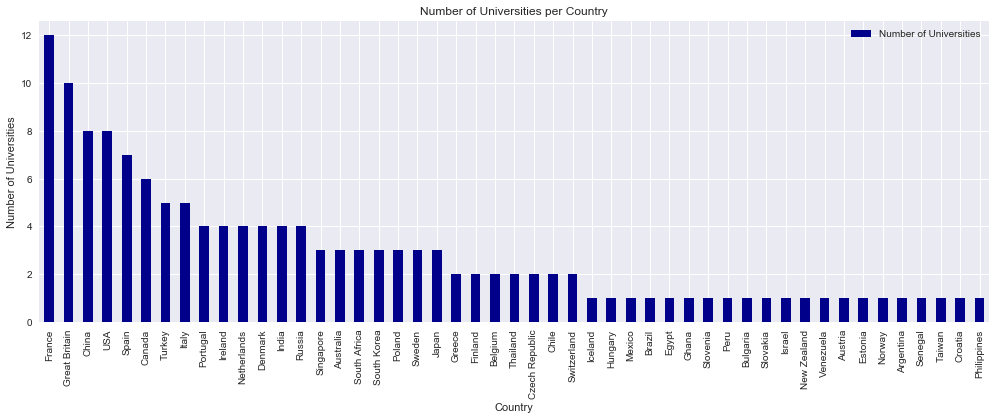

In [29]:
#histogram of universities per country

universities_per_country = pd.DataFrame(df_final_countries_universities_map['Country'].value_counts()).reset_index()
universities_per_country.columns = ['Country','Number of Universities']

universities_per_country.plot(x='Country',
                              y='Number of Universities',
                              kind='bar',
                              color='darkblue',
                              figsize=(14,6),
                              title='Number of Universities per Country')
plt.ylabel('Number of Universities')
plt.tight_layout()

# Geographical Visualizations

In [30]:
#set up data and layout objects for geographical plot

data = dict(
        type = 'choropleth',
        colorscale = 'Blues',
        reversescale = True,
        locations = universities_per_country['Country'],
        locationmode = "country names",
        z = universities_per_country['Number of Universities'],
        text = universities_per_country['Country'],
        colorbar = {'title' : 'Universities'},
      ) 

layout = dict(title = 'Number of Universities per Country',
                geo = dict(showframe = False,projection = {'type':'Mercator'})
             )

In [31]:
choromap = go.Figure(data = [data],layout = layout)

In [32]:
#plot of universities and number of universities on world map

iplot(choromap)